<a href="https://colab.research.google.com/github/otausendschoen/Satellite_Building_Segmentation/blob/main/segmentation_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Group information**

| Family name | First name | Email address |

| Tausendschoen | Oliver | oliver.tausendschoen@bse.eu |

| Gómez Argüelles | Gerardo | gerardo.gomez@bse.eu |


# Semantic segmentation - Homework

This tutorial explores how to automatically extract building footprints from aerial images. The objective is to perform semantic segmentation, or approximate the function that maps input images to class probabilities for each pixel. For this assignment, we use the U-Net convolutional network architecture [(Ronneberger et al. 2015)](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). The GPU implementation of PyTorch is recommended.

The image dataset consists of 3347 colour images, each with dimensions $3 \times 256 \times 256$, sourced from [Minh (2013)](http://www.cs.toronto.edu/~vmnih/data/). Each image corresponds to a 300-square-metre area within the state of Massachusetts. The labels are building footprint vectors derived from [OpenStreetMap](https://www.openstreetmap.org/relation/61315), which have been rasterised into binary masks matching the spatial extent and resolution of the input images. For efficient storage, images and labels are saved in the JPEG format.

![U-Net model](https://www.dropbox.com/scl/fi/wgvqiix6scbm1c983ephk/segmentation_model.jpg?rlkey=71blfq7cm1yzw26puu4l0ybhs&dl=1)

In [1]:
# Packages
import os
import shutil
import torch
import tqdm
!pip install torchmetrics
from matplotlib import pyplot as plt
from torch import nn, optim, utils
from torchmetrics import classification
from torchvision import io, ops
from urllib import request
import numpy as np
import os
import torch
from torch import nn, optim, utils
from torchvision import transforms
from matplotlib import pyplot as plt
from tqdm import tqdm
from skimage import io
from sklearn import metrics
from torch.utils.data import TensorDataset, DataLoader, random_split



# Device
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device = torch.device(device)

# Utilities
classes = {0:'non-building', 255:'building'}

In [2]:
# Utilities
def download_data():
    if os.getcwd().endswith('/data'):
        print('Data folder already exists')
    else:
        request.urlretrieve('https://www.dropbox.com/scl/fo/90urs56ftly5r28jk18i4/AB2AIFdymQmeEqJZ8Og0V4Q?rlkey=nkb2w0fmfuym7sbgqpqnvm9cd&dl=1', 'data.zip')
        shutil.unpack_archive('data.zip', 'data')
        os.remove('data.zip')
        os.chdir('data')

def display_image(image:torch.Tensor, title:str='', cmap:str='gray', figsize=(5, 5)) -> None:
    image   = torch.einsum('dhw -> hwd', image)
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image, cmap=cmap)
    ax.set_title(title, fontsize=15)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()
    plt.close()


def display_image(image: torch.Tensor, title: str = '', cmap: str = 'gray', figsize=(5, 5)) -> None:
    if image.ndim == 3:
        image = torch.einsum('chw -> hwc', image)  # channels first to last
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image, cmap=cmap)
    ax.set_title(title, fontsize=15)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()
    plt.close()


1. Load the images and labels as `torch.Tensor` of dimensions $n \times d \times h \times w$. Normalise the images and labels between 0 and 1 and set the data type as `torch.float32`.

<small>Note: In the label images, pixel values of 0 indicate non-building areas, while 255 indicate buildings. Due to JPEG's lossy compression, some values may slightly differ from 0 or 255. You can round the pixel values to restore binary labels.</small>

In [3]:
#download_data()

image_dir = '/content/drive/MyDrive/Satellite_Building_Segmentation/data/images'
label_dir = '/content/drive/MyDrive/Satellite_Building_Segmentation/data/labels'

# File listing
files  = [file.replace('image_', '') for file in os.listdir(image_dir)]
files  = sorted(files)  # ensures image_i matches label_i
print(f'Total files: {len(files)}')

Total files: 3347


In [4]:
transform = transforms.ToTensor() ## Converts to float32 and scales to [0, 1
images = torch.stack([transform(io.imread(f'{image_dir}/image_{file}')) for file in files])
labels = torch.stack([transform(io.imread(f'{label_dir}/label_{file}'))for file in files])  # Binary mask (1 channel)

2. Check the array dimensions and display several image–label pairs to ensure that they are correctly aligned.

Images shape: torch.Size([3347, 3, 256, 256])
Labels shape: torch.Size([3347, 1, 256, 256])


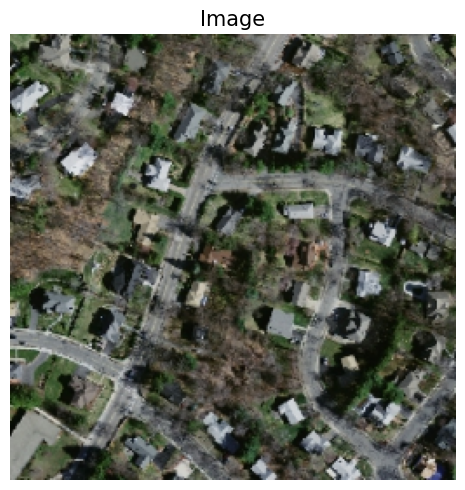

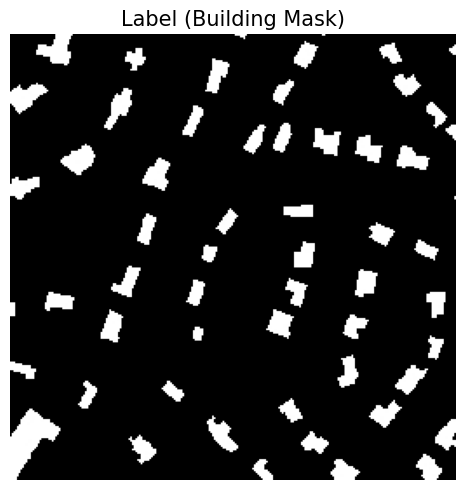

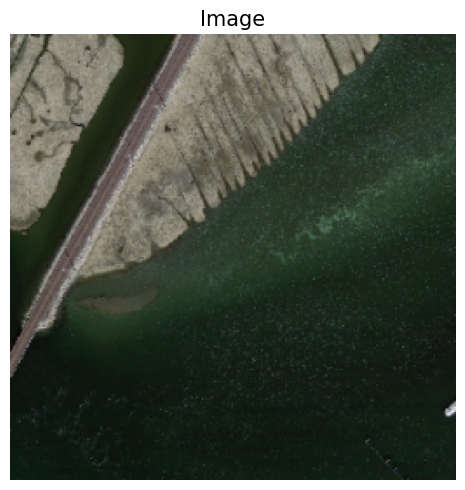

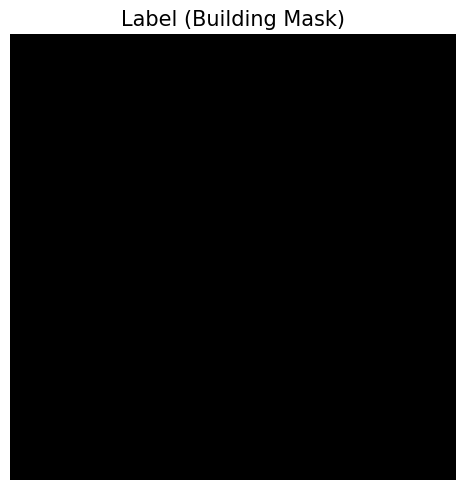

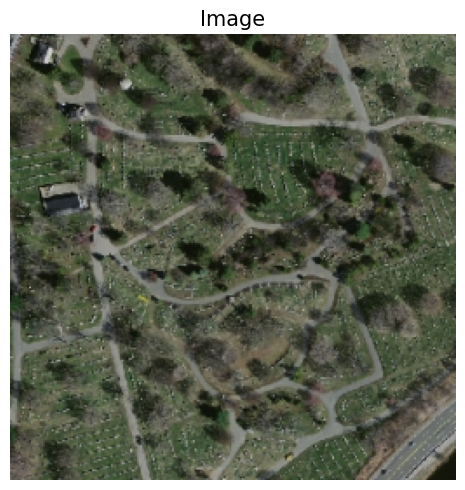

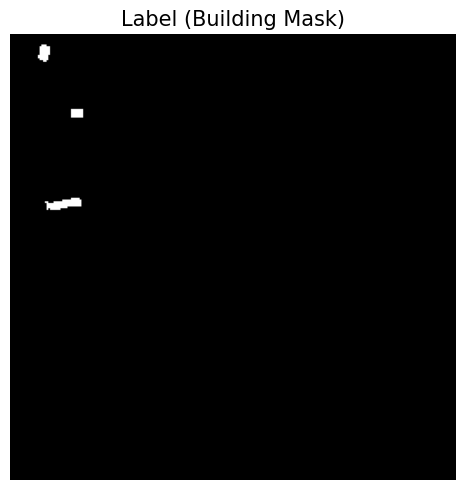

In [5]:
print(f'Images shape: {images.shape}')  # Expect (N, 3, H, W)
print(f'Labels shape: {labels.shape}')  # Expect (N, 1, H, W)

# Display sample
for i in torch.randint(0, len(images), (3,)):
    display_image(image=images[i], title='Image')
    display_image(image=labels[i], title='Label (Building Mask)', cmap='gray')

3. Format the data as a `TensorDataset` and partition the observations into training (75%) and test (25%) samples. For each sample, create a `DataLoader` with a batch size suitable for your hardware (e.g. between 32 and 256).

<small>Note: Optionally, you can also include a validation sample by splitting the dataset into 70% training, 15% validation, and 15% test.</small>

In [6]:
dataset = TensorDataset(images, labels)


# Correctly convert sizes to integers
train_size = int(0.75 * len(dataset))
test_size  = len(dataset) - train_size  # ensures total matches exactly


# Random split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 64  #

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

4. Using PyTorch, define a simplified U-Net model with the number of filters indicated in the figure above (i.e. 8, 16, 32, 64, 128, ...). Choose the appropriate activation functions for the hidden layers and the output layer.

<small>Note: Optionally, you can include batch normalisation and spatial dropout layers to improve the model’s optimisation and generalisation, respectively.</small>

For this task, we used: https://medium.com/@alejandro.itoaramendia/decoding-the-u-net-a-complete-guide-810b1c6d56d8 as a rough guideline

Before building the entire architecure, we will define some helper functions to implement the skip connections in the U-Net.

- center_crop:
Crops the input tensor at the center to match the target spatial size. This is needed to ensure that the sizes of the matching connections during skip connections (encoder and decoder block) match exactly!

- skip_connect:
Performs the skip connection by concatenating the upsampled decoder output with the cropped encoder feature map.



In [ ]:
import torch
import torch.nn as nn
'''
#Helper function for skip connections, we used CHATGPT to help implement they must only be used if we don't use padding!.
def center_crop(tensor, target_size):
    _, _, h, w = tensor.shape
    target_h, target_w = target_size
    delta_h = (h - target_h) // 2
    delta_w = (w - target_w) // 2
    return tensor[:, :, delta_h:delta_h + target_h, delta_w:delta_w + target_w]

def skip_connect(upsampled, encoder_feature):
    cropped = center_crop(encoder_feature, upsampled.shape[2:])
    return torch.cat([upsampled, cropped], dim=1) #1=channel dimension for concatination
'''

# Helper function for skip connections (no cropping needed)
def skip_connect(upsampled, encoder_feature):
    return torch.cat([upsampled, encoder_feature], dim=1)  # Concatenate along the channel dimension


In [8]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1), #NOTE: WE ADDED PADDING TO AVOID SIZE/DIMENSIONALITY ISSUES DURING TRAINING
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1), #NOTE: WE ADDED PADDING TO AVOID SIZE/DIMENSIONALITY ISSUES DURING TRAINING
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.bottleneck = conv_block(512, 1024)

        self.pool = nn.MaxPool2d(2)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b  = self.bottleneck(self.pool(e4))

        # Decoder with skip connections
        d4 = self.up4(b)
        d4 = self.dec4(skip_connect(d4, e4))

        d3 = self.up3(d4)
        d3 = self.dec3(skip_connect(d3, e3))

        d2 = self.up2(d3)
        d2 = self.dec2(skip_connect(d2, e2))

        d1 = self.up1(d2)
        d1 = self.dec1(skip_connect(d1, e1))

        out = self.out_conv(d1)
        #return self.out_activation(out)
        return out


5. Initialise the model and print its architecture. Select an appropriate optimisation algorithm and loss function.

<small>Note: To address class imbalance — since building pixels represent only a small fraction of the total — you can weight the loss function or use loss functions specifically designed for imbalance, such as `torchvision.ops.sigmoid_focal_loss`.</small>


In [9]:
model = UNet(in_channels=3, out_channels=1)
model = model.to(device)

# Print model architecture
print(model)

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0): Conv2d(512, 1024, k

In [10]:
import torch.optim as optim

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Weighted Binary Cross-Entropy Loss
# Building pixels are sparse, so we assign more weight to the positive class (buildings = 1)
pos_weight = torch.tensor([5.0]).to(device)  # Tune this value depending on the level of imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


6. Write the PyTorch training routine and estimate the model parameters using the training sample.

Note: If you use a validation sample, implement a validation routine and apply early stopping to prevent overfitting.

In [11]:
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0.0

    for step, (images, masks) in enumerate(train_loader):
        print(f"Step {step}: Got batch")
        images = images.to(device)               # Shape: (B, 3, H, W)
        masks = masks.to(device)                 # Shape: (B, 1, H, W)

        optimizer.zero_grad()
        logits = model(images)                   # Output: raw logits (B, 1, H, W)
        loss = criterion(logits, masks)          # Compare logits vs masks
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

        if step % 100 == 0:
            print(f'Train Epoch: {epoch} [{step * len(images)}/{len(train_loader.dataset)} '
                  f'({100. * step / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}: Average training loss: {avg_loss:.4f}")

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            logits = model(images)
            loss = criterion(logits, masks)
            test_loss += loss.item() * images.size(0)

    avg_loss = test_loss / len(test_loader.dataset)
    print(f"Test set: Average loss: {avg_loss:.4f}")


In [12]:
print(torch.cuda.memory_summary() if torch.cuda.is_available() else 'Using CPU')

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 123140 KiB | 123140 KiB | 123140 KiB |      0 B   |
|       from large pool | 120448 KiB | 120448 KiB | 120448 KiB |      0 B   |
|       from small pool |   2692 KiB |   2692 KiB |   2692 KiB |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         | 123140 KiB | 123140 KiB | 123140 KiB |      0 B   |
|       from large pool | 120448 KiB | 120448 KiB | 120448 KiB |

In [13]:
num_epochs = 30

for epoch in range(1, num_epochs + 1):
    train(model, train_loader, optimizer, criterion, epoch)
    test(model, test_loader, criterion)


Step 0: Got batch
Train Epoch: 1 [0/2510 (0%)]	Loss: 1.000872
Step 1: Got batch
Step 2: Got batch
Step 3: Got batch
Step 4: Got batch
Step 5: Got batch
Step 6: Got batch
Step 7: Got batch
Step 8: Got batch
Step 9: Got batch
Step 10: Got batch
Step 11: Got batch
Step 12: Got batch
Step 13: Got batch
Step 14: Got batch
Step 15: Got batch
Step 16: Got batch
Step 17: Got batch
Step 18: Got batch
Step 19: Got batch
Step 20: Got batch
Step 21: Got batch
Step 22: Got batch
Step 23: Got batch
Step 24: Got batch
Step 25: Got batch
Step 26: Got batch
Step 27: Got batch
Step 28: Got batch
Step 29: Got batch
Step 30: Got batch
Step 31: Got batch
Step 32: Got batch
Step 33: Got batch
Step 34: Got batch
Step 35: Got batch
Step 36: Got batch
Step 37: Got batch
Step 38: Got batch
Step 39: Got batch
Epoch 1: Average training loss: 1.0043
Test set: Average loss: 0.9592
Step 0: Got batch
Train Epoch: 2 [0/2510 (0%)]	Loss: 0.995477
Step 1: Got batch
Step 2: Got batch
Step 3: Got batch
Step 4: Got batch
St

7. Compute the predicted probabilities for the test images.

Test images shape: torch.Size([837, 3, 256, 256])
Test masks shape: torch.Size([837, 1, 256, 256])
Predicted probabilities shape: torch.Size([837, 1, 256, 256])


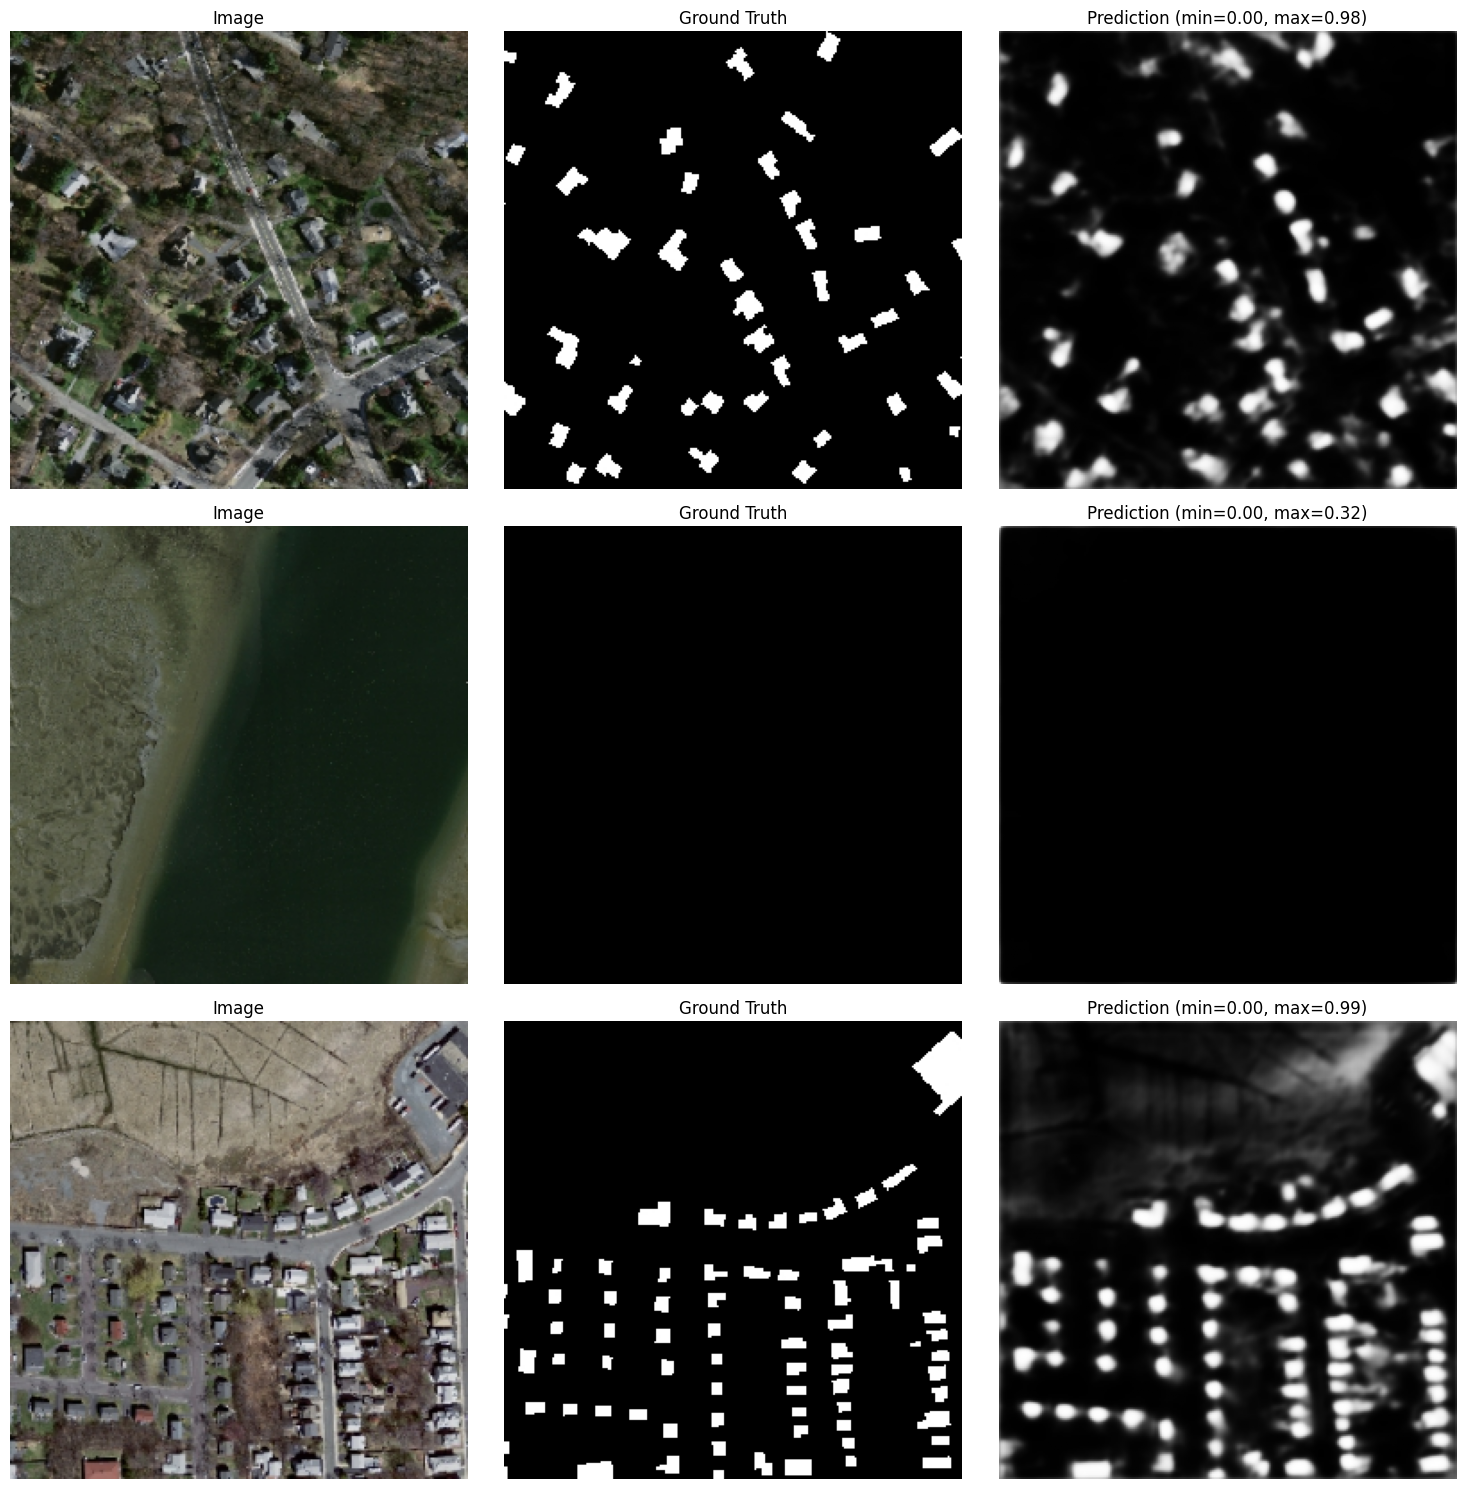

Prediction min: 8.990861033453257e-08, max: 0.9978523254394531
Prediction mean: 0.1989971548318863, std: 0.2997388243675232


In [14]:

# Set model to evaluation mode
model.eval()
predicted_probs = []
test_images = []
test_masks = []

# Collect test images, masks, and predictions
with torch.no_grad():
    for images, masks in test_loader:
        # Store the images and masks
        test_images.append(images.cpu())
        test_masks.append(masks.cpu())

        # Get predictions
        images = images.to(device)
        logits = model(images)
        probs = torch.sigmoid(logits)  # Convert logits to probabilities
        predicted_probs.append(probs.cpu())

# Concatenate all collected tensors
test_images = torch.cat(test_images, dim=0)
test_masks = torch.cat(test_masks, dim=0)
predicted_probs = torch.cat(predicted_probs, dim=0)

print(f"Test images shape: {test_images.shape}")
print(f"Test masks shape: {test_masks.shape}")
print(f"Predicted probabilities shape: {predicted_probs.shape}")

# Visualize some results
num_samples = 3
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
for i in range(num_samples):
    idx = i

    # Test_images[idx] has a shape of [channels, height, width] (PyTorch's standard format),
    # The operation converts it to [height, width, channels] format, which is what matplotlib's imshow function expects
    img = torch.einsum('chw->hwc', test_images[idx])

    # Original image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Image")
    axes[i, 0].axis('off')

    # Ground truth mask
    axes[i, 1].imshow(test_masks[idx].squeeze(), cmap='gray')
    axes[i, 1].set_title(f"Ground Truth")
    axes[i, 1].axis('off')

    # Prediction probability
    axes[i, 2].imshow(predicted_probs[idx].squeeze(), cmap='gray')
    min_val = predicted_probs[idx].min().item()
    max_val = predicted_probs[idx].max().item()
    axes[i, 2].set_title(f"Prediction (min={min_val:.2f}, max={max_val:.2f})")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

# Check predictions
print(f"Prediction min: {predicted_probs.min().item()}, max: {predicted_probs.max().item()}")
print(f"Prediction mean: {predicted_probs.mean().item()}, std: {predicted_probs.std().item()}")


8. Assess the model's generalisation performance by computing the confusion matrix, along with precision and recall metrics on the test sample. Comment on the results.

In [19]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Threshold to convert probabilities to binary predictions
threshold = 0.5

# Flatten predictions and ground truth for metric computation
predicted_labels = (predicted_probs > threshold).int().flatten().cpu().numpy()
true_labels = test_masks.int().flatten().cpu().numpy()

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])
print("Confusion Matrix:")
print(conf_matrix)
print("\nConfusion Matrix Interpretation:")
print(f"True Negatives: {conf_matrix[0, 0]}")
print(f"False Positives: {conf_matrix[0, 1]}")
print(f"False Negatives: {conf_matrix[1, 0]}")
print(f"True Positives: {conf_matrix[1, 1]}")

# Compute precision and recall
precision = precision_score(true_labels, predicted_labels, pos_label=1)
recall = recall_score(true_labels, predicted_labels, pos_label=1)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate class imbalance in test set
building_pixels = true_labels.sum()
total_pixels = len(true_labels)
building_percentage = building_pixels / total_pixels * 100

print(f"\nClass distribution in test set:")
print(f"Building pixels: {building_pixels} ({building_percentage:.2f}%)")
print(f"Non-building pixels: {total_pixels - building_pixels} ({100 - building_percentage:.2f}%)")

Confusion Matrix:
[[44349245  4396240]
 [ 1034692  5073455]]

Confusion Matrix Interpretation:
True Negatives: 44349245
False Positives: 4396240
False Negatives: 1034692
True Positives: 5073455

Precision: 0.5358
Recall: 0.8306
F1 Score: 0.6514

Class distribution in test set:
Building pixels: 6108147 (11.14%)
Non-building pixels: 48745485 (88.86%)


In [23]:
# Interpretation template
print("\nModel Generalization Performance Assessment:")
print("--------------------------------------------")
print("The confusion matrix shows how well our model generalizes to unseen data:")
print(f"- Out of all non-building pixels, the model correctly identified {conf_matrix[0, 0]} pixels as background")
print(f"  but incorrectly classified {conf_matrix[0, 1]} background pixels as buildings.")
print(f"- Out of all building pixels, the model correctly identified {conf_matrix[1, 1]} pixels as buildings")
print(f"  but missed {conf_matrix[1, 0]} building pixels.")


Model Generalization Performance Assessment:
--------------------------------------------
The confusion matrix shows how well our model generalizes to unseen data:
- Out of all non-building pixels, the model correctly identified 44329595 pixels as background
  but incorrectly classified 4280417 background pixels as buildings.
- Out of all building pixels, the model correctly identified 5189278 pixels as buildings
  but missed 1054342 building pixels.


**True Negatives (44,349,245)**: The model correctly identified most non-building pixels as background, showing good performance on the majority class.

**False Positives (4,396,240)**: About 9% of the pixels predicted as buildings were actually background areas. This indicates moderate over-prediction of buildings.

**False Negatives (1,034,692)**: Only about 17% of actual building pixels went undetected, showing the model is fairly good at finding buildings.

**True Positives (5,073,455)**: The model successfully detected most building pixels in the test set.


The precision of **0.5358** indicates that only about 54% of pixels the model classified as buildings are actually buildings. This false positive rate suggests our model is somewhat over-eager in identifying buildings, possibly detecting shadows, roads, or other similar-looking features as buildings.

The recall of **0.8306** is quite strong, indicating that our model detected about 83% of all actual building pixels. This high recall would be valuable in applications where missing buildings would be costly, such as urban planning or disaster response.

The F1 score of **0.6514** balances these two metrics and shows moderately good overall performance. While there's certainly room for improvement in precision, the model demonstrates reasonable generalization capability given the significant class imbalance in the dataset.

9. Implement a function to visualise true positives, true negatives, false positives, and false negatives as overlays on the input image.

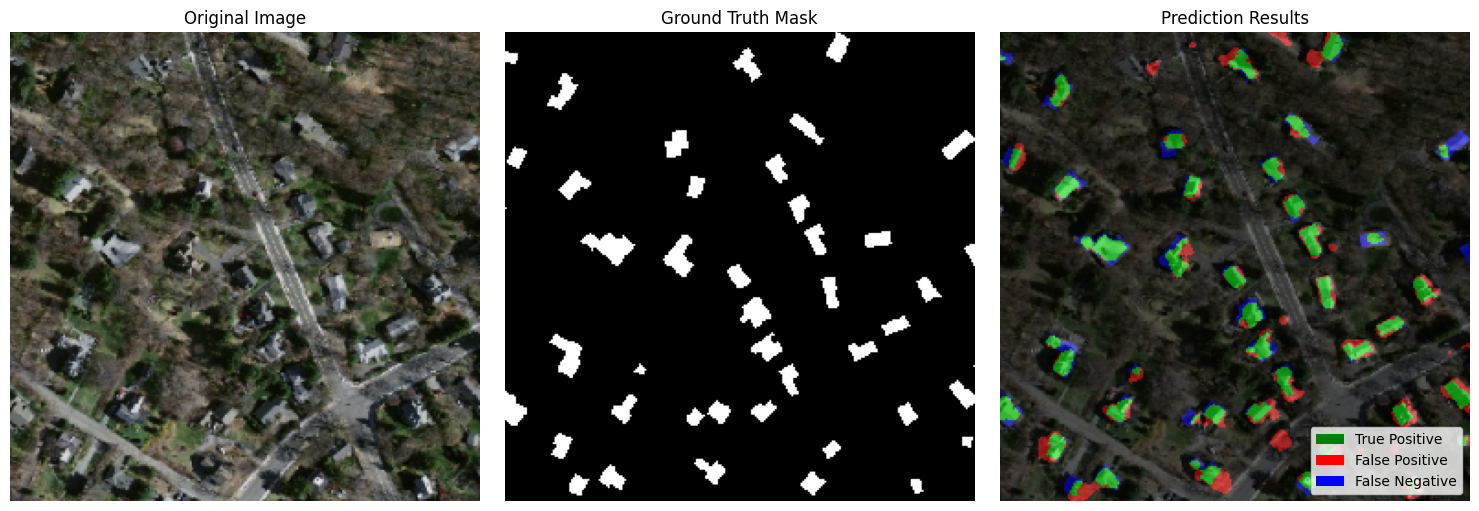

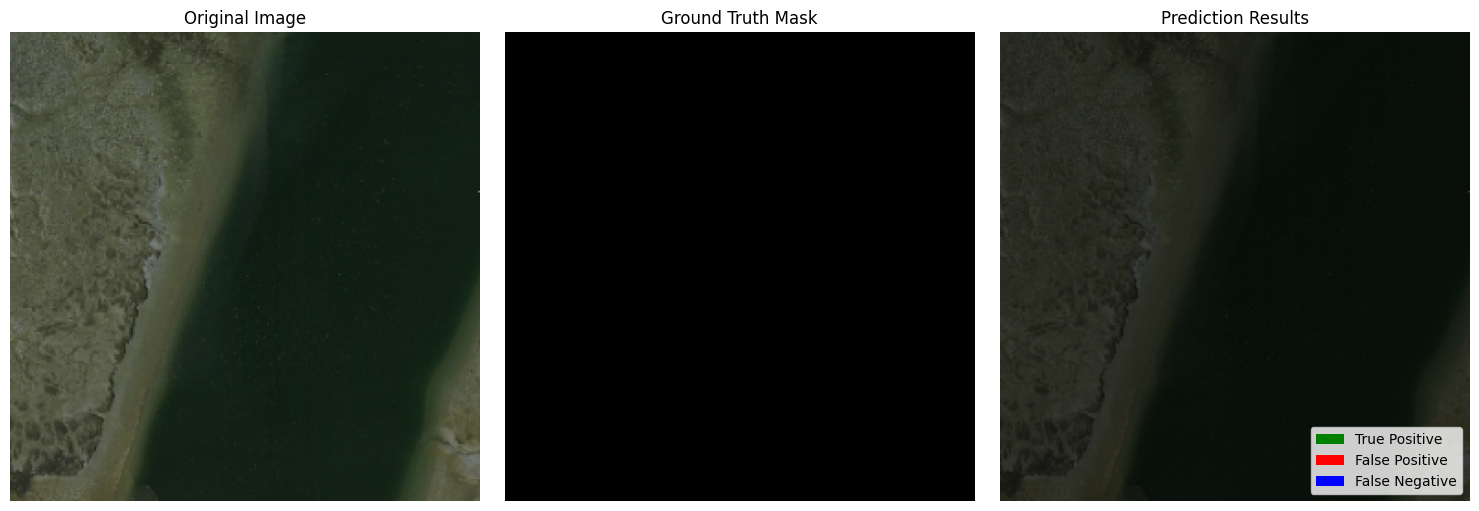

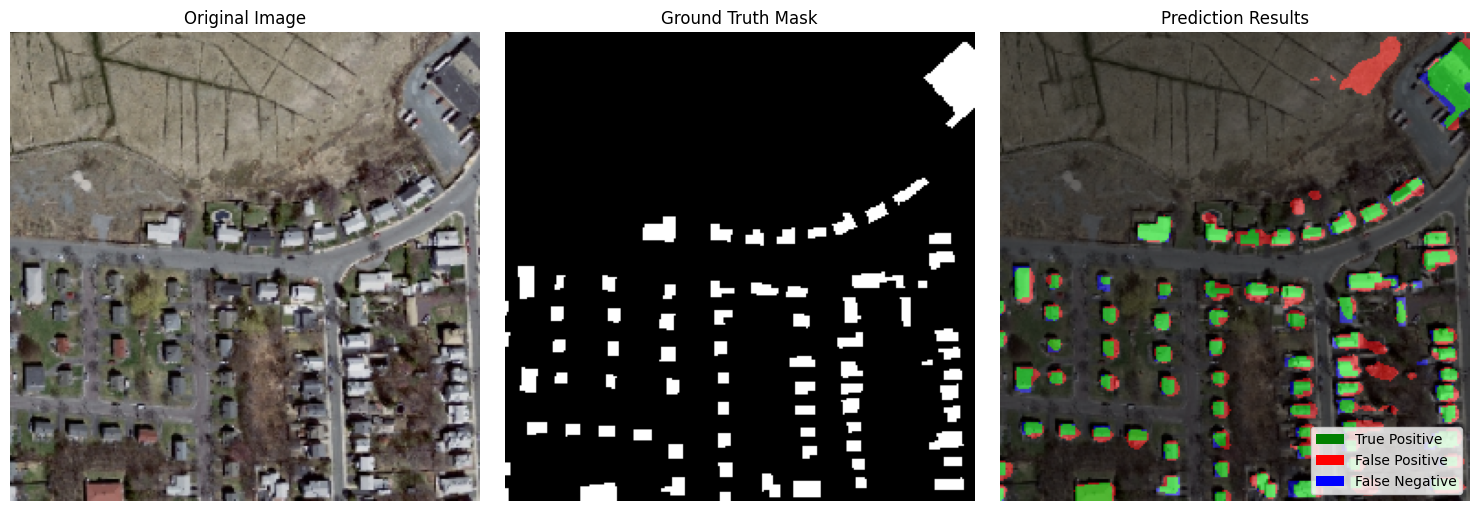

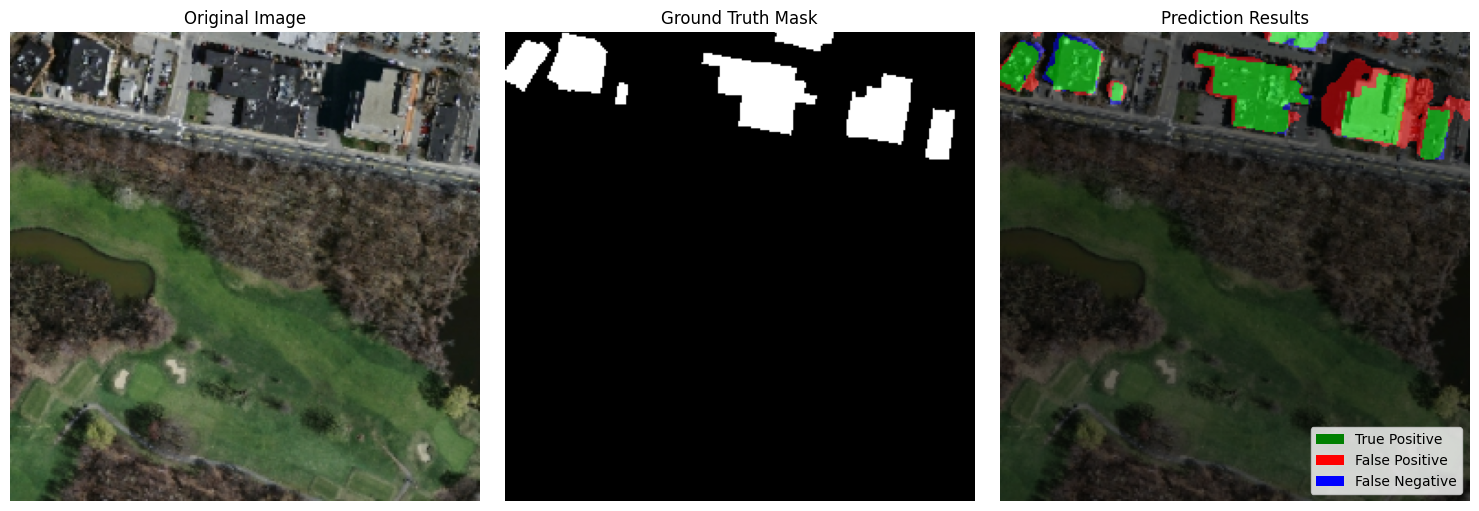

In [26]:
def visualize_predictions(image, true_mask, pred_probs, threshold=0.5):

    # Make sure everything is in the right format
    if isinstance(image, torch.Tensor):
        if image.shape[0] == 3:
            image = image.permute(1, 2, 0).cpu().numpy()
        else:
            image = image.cpu().numpy()

    # Get binary masks
    true_binary = true_mask.squeeze().cpu().numpy() > 0.5
    pred_binary = pred_probs.squeeze().cpu().numpy() > threshold

    # Create a blank RGB overlay
    overlay = np.zeros((*true_binary.shape, 3))

    # Color code the prediction results
    overlay[true_binary & pred_binary] = [0, 1, 0]  # True Positive: Green
    overlay[~true_binary & pred_binary] = [1, 0, 0]  # False Positive: Red
    overlay[true_binary & ~pred_binary] = [0, 0, 1]  # False Negative: Blue

    # Display the results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Ground truth
    axes[1].imshow(true_binary, cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    # Overlay predictions on image
    axes[2].imshow(image)
    axes[2].imshow(overlay, alpha=0.5)
    axes[2].set_title('Prediction Results')
    axes[2].axis('off')

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', label='True Positive'),
        Patch(facecolor='red', label='False Positive'),
        Patch(facecolor='blue', label='False Negative')
    ]
    axes[2].legend(handles=legend_elements, loc='lower right')

    plt.tight_layout()
    plt.show()

# Display multiple examples
def show_prediction_examples(model, test_loader, num_examples=3):
    model.eval()
    examples_shown = 0

    with torch.no_grad():
        for images, masks in test_loader:
            # Process only what we need
            batch_size = min(len(images), num_examples - examples_shown)

            # Get predictions
            batch_images = images[:batch_size].to(device)
            logits = model(batch_images)
            probs = torch.sigmoid(logits)

            # Show visualizations
            for i in range(batch_size):
                visualize_predictions(
                    images[i],
                    masks[i],
                    probs[i].cpu()
                )
                examples_shown += 1

            if examples_shown >= num_examples:
                break

show_prediction_examples(model, test_loader, num_examples=4)

10. Assuming that we give equal importance to reducing false positives and false negatives, use a decision probability threshold that strikes the best balance between these two quantities.

Threshold  Fals Pos     False Neg    Total Errors |FP-FN|   
------------------------------------------------------------
0.10       13,968,541   184,249      14,152,790   13,784,292
0.12       13,018,337   214,886      13,233,223   12,803,451
0.13       12,202,966   245,231      12,448,197   11,957,735
0.15       11,488,544   275,827      11,764,371   11,212,717
0.17       10,854,484   306,626      11,161,110   10,547,858
0.18       10,286,762   337,225      10,623,987   9,949,537 
0.20       9,770,786    368,457      10,139,243   9,402,329 
0.21       9,297,815    399,622      9,697,437    8,898,193 
0.23       8,862,010    431,440      9,293,450    8,430,570 
0.25       8,456,148    463,903      8,920,051    7,992,245 
0.26       8,079,078    496,691      8,575,769    7,582,387 
0.28       7,724,250    529,898      8,254,148    7,194,352 
0.30       7,389,239    563,475      7,952,714    6,825,764 
0.31       7,072,623    597,607      7,670,230    6,475,016 
0.33       6,772,251    

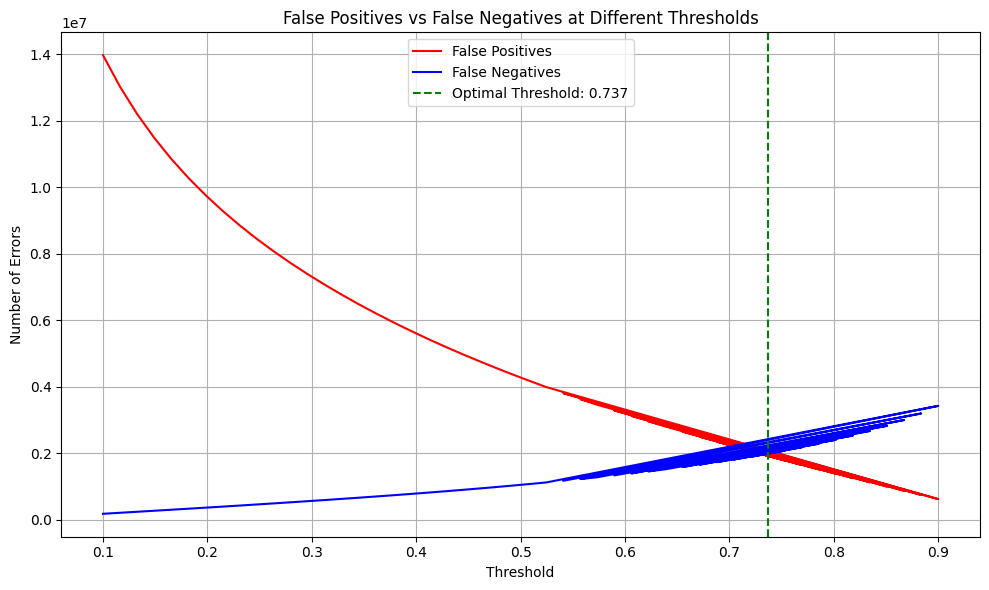


Optimal threshold: 0.737
False Positives: 1,924,877
False Negatives: 1,988,707
Absolute difference: 63,830
Precision: 0.6885
Recall: 0.6815
F1 Score: 0.6850


In [28]:
def find_optimal_threshold(model, test_loader, num_thresholds=50):
    model.eval()

    # Collect all predictions and ground truths
    all_preds = []
    all_masks = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)

            all_preds.append(probs.cpu())
            all_masks.append(masks.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds, dim=0)
    all_masks = torch.cat(all_masks, dim=0)

    # Flatten for easier processing
    flat_preds = all_preds.flatten()
    flat_masks = all_masks.flatten()

    # Testing different thresholds
    thresholds = torch.linspace(0.1, 0.9, num_thresholds)
    results = []

    for threshold in thresholds:
        pred_binary = (flat_preds > threshold).int()
        true_binary = (flat_masks > 0.5).int()

        # Calculate FP and FN
        fp = torch.sum((pred_binary == 1) & (true_binary == 0)).item()
        fn = torch.sum((pred_binary == 0) & (true_binary == 1)).item()

        # Calculate the absolute difference between FP and FN
        diff = abs(fp - fn)

        # Store results
        results.append({
            'threshold': threshold.item(),
            'fp': fp,
            'fn': fn,
            'diff': diff,
            'total_errors': fp + fn
        })

    # Find threshold with minimum difference between FP and FN
    results.sort(key=lambda x: x['diff'])
    best_result = results[0]

    # Visualization
    print(f"{'Threshold':<10} {'Fals Pos':<12} {'False Neg':<12} {'Total Errors':<12} {'|FP-FN|':<10}")
    print("-" * 60)

    for res in sorted(results, key=lambda x: x['threshold']):
        print(f"{res['threshold']:<10.2f} {res['fp']:<12,d} {res['fn']:<12,d} {res['total_errors']:<12,d} {res['diff']:<10,d}")

    # Plot
    plt.figure(figsize=(10, 6))

    thresholds = [res['threshold'] for res in results]
    fps = [res['fp'] for res in results]
    fns = [res['fn'] for res in results]

    plt.plot(thresholds, fps, 'r-', label='False Positives')
    plt.plot(thresholds, fns, 'b-', label='False Negatives')
    plt.axvline(x=best_result['threshold'], color='g', linestyle='--',
                label=f'Optimal Threshold: {best_result["threshold"]:.3f}')

    plt.xlabel('Threshold')
    plt.ylabel('Number of Errors')
    plt.title('False Positives vs False Negatives at Different Thresholds')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Calculate metrics at best threshold
    best_threshold = best_result['threshold']
    pred_binary = (flat_preds > best_threshold).int()
    true_binary = (flat_masks > 0.5).int()

    tp = torch.sum((pred_binary == 1) & (true_binary == 1)).item()
    tn = torch.sum((pred_binary == 0) & (true_binary == 0)).item()
    fp = torch.sum((pred_binary == 1) & (true_binary == 0)).item()
    fn = torch.sum((pred_binary == 0) & (true_binary == 1)).item()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\nOptimal threshold: {best_threshold:.3f}")
    print(f"False Positives: {fp:,}")
    print(f"False Negatives: {fn:,}")
    print(f"Absolute difference: {abs(fp - fn):,}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return best_threshold

# Find the optimal threshold
optimal_threshold = find_optimal_threshold(model, test_loader)